# Alumno: Gerardo de Miguel González

## Ejercicio de regularización

### Horner Gaussiano

 1. Escribe una función de R que reciba como input un vector "x" con la variable dependiente, un vector de parámetros "betas" que contenga los coeficientes de un polinomio y una sigma "sigma"; y que devuelva el vector dependiente que siga la ley polinomial dada con PDF gaussiana y sigma dada.  

In [1]:
#::GMG::Algoritmo de Horner vectorizado para hallar el valor de un polinomio
#       x: variable independiente
#       v: vector de coeficientes en x^0, x^1, ..., x^p
horner <- function(x, v) {
  Reduce(v, right=T, f=function(a, b) {
    b * x + a
  })
}

In [2]:
#::GMG::Función que genera el polinomio junto con un ruido distribuido
#       N(0,sigma)
pol <- function (x,betas,sigma) {
    return(horner(x,betas) + rnorm(length(x),0,sigma))
}

 2. Construye un vector de 40 elementos distribuido uniformemente entre [-3, 3]. Úsalo con la función anterior, el polinomio: $x^3 + 2 x^2 - x - 2$ y $\sigma = 4$. Representa los datos resultantes.

**::GMG::** Los `ISSUE` en los comentarios son el feedback del profesor; las líneas de código comentadas son las que he corregido derivadas de los comentarios recibidos.

In [3]:
#::GMG::Nube de puntos del polinonio solicitado con el ruido gaussiano
#::ISSUE::No has tomado tus abscisas de forma aleatoria, y tampoco tu división
#entre train y test lo es. De esta forma, la validación cruzada es muy
#artificial. No ya por usar un hold out, sino porque no es aleatorio
#::ISSUE::No has cogido los 40 puntos pedidos, sino 41. ¿Por qué usas el número
#mágico by=6/40? Prueba el argumento length.out
#x <- seq(from = -3, to = 3, by = 6/40)
x <- seq(from = -3, to = 3, length.out = 40)

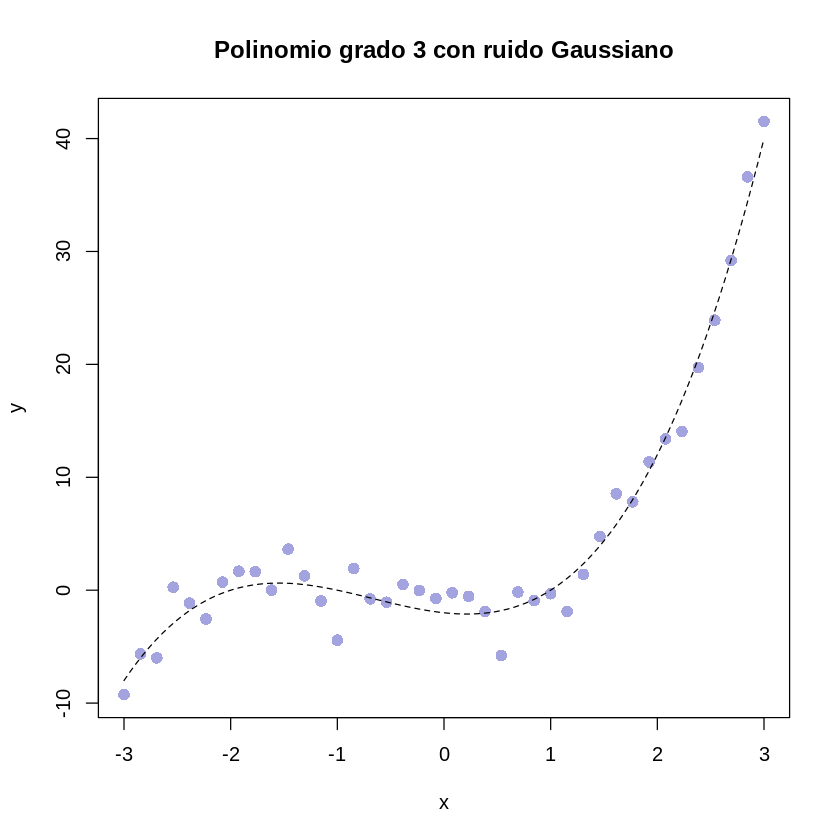

In [4]:
#::GMG::Dibujo la curva de referencia y los puntos generados
# https://stat.ethz.ch/R-manual/R-devel/library/graphics/html/curve.html
b <- c(-2,-1,2,1)
sigma <- 2
set.seed(1)
y <- pol(x,b,sigma)
plot(x,y, 
     col=rgb(0.4,0.4,0.8,0.6),
     pch=16 ,cex=1.3, 
     main = 'Polinomio grado 3 con ruido Gaussiano')
curve(expr = horner(x = x, v = b),from = -3, to = 3, add = T, lwd = 1, lty = 2)

 3. Calcula el valor mínimo de la función de coste (_loss_, RSS) para el caso en que hacemos un ajuste con una recta (dos parámetros), una parábola (tres parámetros), 4, 5, 6 y 7 parámetros, usando los primeros 20 puntos. Con los valores que hacen mínimo el RSS para la muestra de entrenamiento, calcula el RSS para los siguientes 20 puntos. Pinta los resultados en función del número de parámetros para ambos casos.

### Train/Test

In [5]:
#::GMG::Selecciono los "primeros 20 puntos" como "train"
#::ISSUE::No has tomado tus abscisas de forma aleatoria, y tampoco tu división
#entre train y test lo es. De esta forma, la validación cruzada es muy
#artificial. No ya por usar un hold out, sino porque no es aleatorio
#::ISSUE::La división que proponía al 50% es para no liarnos con el tamaño de
#muestra. Por ejemplo, el RSS depende del tamaño de muestra. Cuanto mayor
#es la muestra, mayor es en general el RSS ya que no está normalizado.
#Tomando mitad y mitad, son comparables los RSS de train y test (prueba a
#dibujarlos en la misma gráfica). En una situación más realista, haríamos
#un k-fold en lugar de un hold-out.
#mitad <- 1:20
#x_train <- x[mitad]
#y_train <- y[mitad]
#x_test <- x[-mitad]
#y_test <- y[-mitad]
#::nota:: hold-out validation correctly: splitting the dataset into 2 parts 
#         and using one for training and the other for testing
# https://stackoverflow.com/questions/17200114/how-to-split-data-into-training-testing-sets-using-sample-function
# https://stat.ethz.ch/R-manual/R-devel/library/base/html/sample.html
set.seed(1)
#::GMG::hold-out 50%  
sample <- sample.int(n = length(x), 
                     size = floor(0.50*length(x)), 
                     replace = F)
x_train <- x[sample]
y_train <- y[sample]
x_test  <- x[-sample]
y_test  <- y[-sample]

### Función de coste

In [6]:
#::GMG::Defino la función de coste (loss, rss)
#::nota::beta es el vector de coeficientes de regresión, i.e 
#        beta_0, beta_1, ... beta_p de x_0, x_1, ... x_p o x^0, x^1, ..., x^p
#        x son las 'features' de la matriz de diseño (1,x)
rss <- function(betas,x,y) {
    i <- rep(1, length(y))
    X <- cbind(i,x)
    B <- matrix(betas, nrow = length(betas))
    Y <- matrix(y, nrow = length(y))
    return (as.numeric(t(Y - X %*% B) %*% (Y - X %*% B)))
}

In [7]:
#::GMG::Hablamos primero de una regresión lineal con intercept y slope
#       La hago primero de forma "manual": calculo los dos parámetros
#::nota::caso recta, i.e polinomio de grado 1

#::ISSUE::Desde el punto de vista, no ya de data scientist profesional, sino de
#programación, trata de programar funciones más genéricas. Por ejemplo,
#separas el ajuste a una recta del ajuste a un polinomio de grado n. La
#recta es un caso particular de éste. Después tendrás que hacer lo mismo
#con regularización. Pero el caso sin regularización es también un caso
#particular de éste (con lambda=0). El código se simplifica mucho de esta
#manera, y se entiende mejor el efecto del orden del polinomio y del
#papel de lambda.

#X <- cbind(rep(1,20), x_train)
#Y <- matrix(y_train, nrow=length(y_train))
#b_hat <- solve(t(X)%*%X)%*%t(X)%*%Y
#b_0_hat <- b_hat[1,1]
#b_1_hat <- b_hat[2,1]
#p_lm <- c(b_0_hat,b_1_hat)
#names(p_lm) <- c('intercept','x_train')
#print(p_lm)
#paste('rss:', round(rss(betas = p_lm, x = x_train, y = y_train),2))

### Regresión Matricial Polinomial

In [8]:
#::GMG::Programo la función que resuelve 'ordinary least squares' (OLS)
#       las betas de forma matricial en una regresión lineal múltiple
betas <- function(x,y) {
    i <- rep(1, length(y))
    X <- cbind(i,x)
    Y <- matrix(y, nrow = length(y))
    B_hat <- solve(t(X) %*% X) %*% t(X) %*% Y
    return (as.numeric(B_hat))
}

In [9]:
#::GMG::Me hago mi función de regresión lineal con rss() y betas()
mi_lm <- function(x,y) {
    coef <- betas(x = x,y = y)
    loss <- rss(betas = coef,x = x,y = y)
    list(coeficientes = coef, rss = loss)
}

In [10]:
#::GMG::Prueba de funcionamiento
#mi_model <- mi_lm(x = poly(x_train,2, raw = T), y = y_train)
#round(mi_model$coeficientes,2)
#paste('rss:',round(mi_model$rss,2))
#model <- lm(y_train~poly(x_train,2,raw = T))
#print(round(model$coefficients,3))
#paste('rss:',round(sum(model$residuals^2),2),
#      '(', round(rss(betas = model$coefficients, 
#                     x = poly(x_train,2, raw = T), 
#                     y = y_train),2), ')')

In [11]:
#::GMG::Usamos la función poly() para construir los polinomios de regresión
#       i.e. x^1, x^2, ..., x^p de la matriz de diseño para los betas
# https://www.rdocumentation.org/packages/stats/versions/3.5.1/topics/poly
#x_3 <- cbind(x_train^1,x_train^2,x_train^3)
#head(x_3)
#x_3_b <- poly(x_train, 3,raw = T)
#head (x_3_b)

In [12]:
#::GMG::La regresión lineal simple se puede hacer con lm()
#::ISSUE::este problema lo planteaba para hacerlo
#sin lm(). Hasta el momento te ha servido, pero lm() no tiene
#implementada la regularización que viene a continuación.
#model_1 <- lm(y_train~x_train)
#print(round(model_1$coefficients,3))

#::GMG:: El valor de loss/rss lo puedo calcular aquí con los 'residuos' 
#        que proporciona el objeto model_1
#paste('rss:',round(sum(model_1$residuals^2),2),
#      '(', round(rss(betas = model_1$coefficients, x = x_train, y = y_train),2), ')')

In [13]:
#::GMG::EL caso polinomial, usando lm() y poly()
# https://www.rdocumentation.org/packages/stats/versions/3.5.1/topics/poly
#model_2_b <- lm(y_train~poly(x_train, 2,raw = T))
#print(round(as.vector(t(model_2_b$coef)),2))
#paste('rss:',round(sum(model_2_b$residuals^2),2) ,
#      '(', round(rss(betas = model_2_b$coefficients, 
#                     x = cbind(x_train, x_train^2), 
#                     y = y_train),2), ')'
#)

### Resultados

In [14]:
#::GMG::Usando lm(), poly() y residuals calculo y pinto los rss
#       con polinomios de grado 2 a 7 para los 20 puntos de train

#::ISSUE::este problema lo planteaba para hacerlo
#sin lm(). Hasta el momento te ha servido, pero lm() no tiene
#implementada la regularización que viene a continuación.

# https://stackoverflow.com/questions/13444524/populating-a-list-with-lm-objects
#model <- list()
#loss <- c()
##for (i in 1:7) {
##    model[[i]] <- lm(y_train~poly(x_train, i,raw = T)) 
##    loss[i] <- sum(model[[i]]$residuals^2)
##}
#for (i in 1:7) {
#    model[[i]] <- lm(y_train~poly(x_train, i,raw = T)) 
#    loss[i] <- rss(betas = model[[i]]$coefficients, 
#                   x = poly(x = x_train,degree = i, raw = T), 
#                   y = y_train)
#}
#model[[1]]
#loss

In [15]:
# ::GMG::Pintamos los diferentes modelos que hemos obtenido en train 
#plot(x_train,y_train, pch = 16, cex = 1.3, col = "blue")
#for (i in 1:7) {
#  points(x_train, fitted(model[[i]]), col=i+1, pch=20, type='b')
#}

In [16]:
#::GMG::Hago la predicción para los puntos de test
#loss_pred <- c()
#pred <- list()
#for (i in 1:7) {
#    pred[[i]] <- predict(model[[i]], newdata = data.frame(x_test,y_test))
#    loss_pred[i] <- rss(betas = model[[i]]$coefficients, 
#                        x = poly(x = x_test,degree = i, raw = T), 
#                        y = y_test)
#}

In [17]:
# https://stackoverflow.com/questions/47890742/logarithmic-scale-plot-in-r
#log10Tck <- function(side, type){
#   lim <- switch(side, 
#     x = par('usr')[1:2],
#     y = par('usr')[3:4],
#     stop("side argument must be 'x' or 'y'"))
#   at <- floor(lim[1]) : ceiling(lim[2])
#   return(switch(type, 
#     minor = outer(1:9, 10^(min(at):max(at))),
#     major = 10^at,
#     stop("type argument must be 'major' or 'minor'")
#   ))
#}

In [18]:
#::GMG::Dibujo la evolución de rss en función del grado para el test
# https://stackoverflow.com/questions/47890742/logarithmic-scale-plot-in-r
# http://www.sthda.com/english/wiki/axis-scale-in-r-software-minimum-maximum-and-log-scale
# https://stat.ethz.ch/pipermail/r-help/2010-March/232593.html
#plot(1:7,loss_pred, log='y', axes = F,
#     type = 'b', col = 'red', 
#     xlab = 'grado', ylab = 'log(loss/rss) Test',
#     panel.first=abline(v=c(1,2,3,4,5,6,7),
#                        h=c(1e+04,1e+05,1e+06,1e+07,1e+08,1e+09), 
#                        lty=3,
#                        col="gray"),
#     main = 'RSS/Loss Test regresión lineal polinomial')
#axis(1) # normal x axis
#axis(2, at=log10Tck('y','major'), tcl= 0.2)
#axis(2, at=log10Tck('y','minor'), tcl= 0.1, labels=NA)

In [19]:
#::GMG::Pinto los modelos obtenidos para el test 
#plot(x_test,y_test, pch = 16, cex = 1.3, col = "blue")
#for (i in 1:7) {
#  points(x_test, pred[[i]], col=i+1, type = 'b')
#}

In [20]:
#::GMG::calculo y pinto los rss para el train com mi_lm() hasta grado 7
model <- list()
loss_tn <- c()
for (i in 1:7) {
    model[[i]] <- mi_lm(x = poly(x_train, i,raw = T), y = y_train) 
    loss_tn[i] <- model[[i]]$rss
}

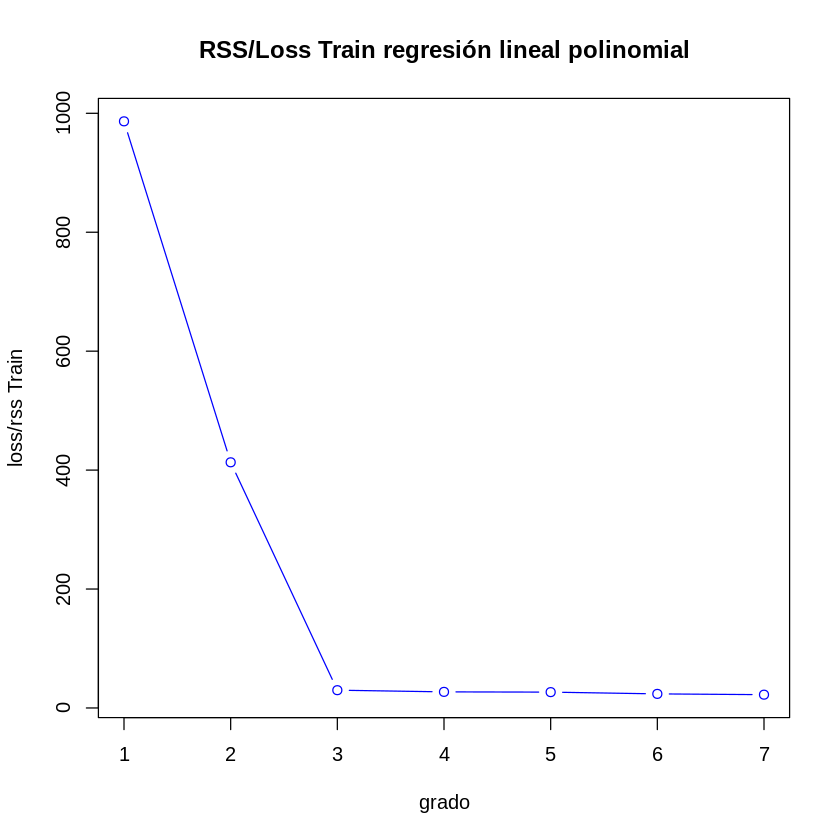

In [21]:
#::GMG::Dibujo la evolución de rss en función del grado
plot(1:7,loss_tn, type = 'b', col = 'blue', 
     xlab = 'grado', ylab = 'loss/rss Train', 
     main = 'RSS/Loss Train regresión lineal polinomial')

In [22]:
#::GMG::Hago mi función predict con fórmula matricial y rss()
mi_predict <- function (model,x,y) {
    coef <- model$coeficientes
    B_hat <- as.matrix(coef)
    i <- rep(1, length(y))
    X <- cbind(i,x)
    y_hat <- X%*%B_hat
    #::nota:: esto es INCORRECTO: y_p <- horner(x = x, v = coef)
    #::nota::aquí se puede hacer también loss <- sum((y - y_p)^2)
    loss <- rss(betas = coef,x = x,y = y)
    list(y_pred = y_hat, rss = loss)
}

In [23]:
#::GMG::Hago la predicción en el conjunto de test para los modelos
#       Validación (hold-out)
p <- list()
loss_tt <- c()
for (i in 1:7) {
    p[[i]] <- mi_predict(model = model[[i]],poly(x_test, i,raw = T), y_test)
    loss_tt[i] <- p[[i]]$rss
}

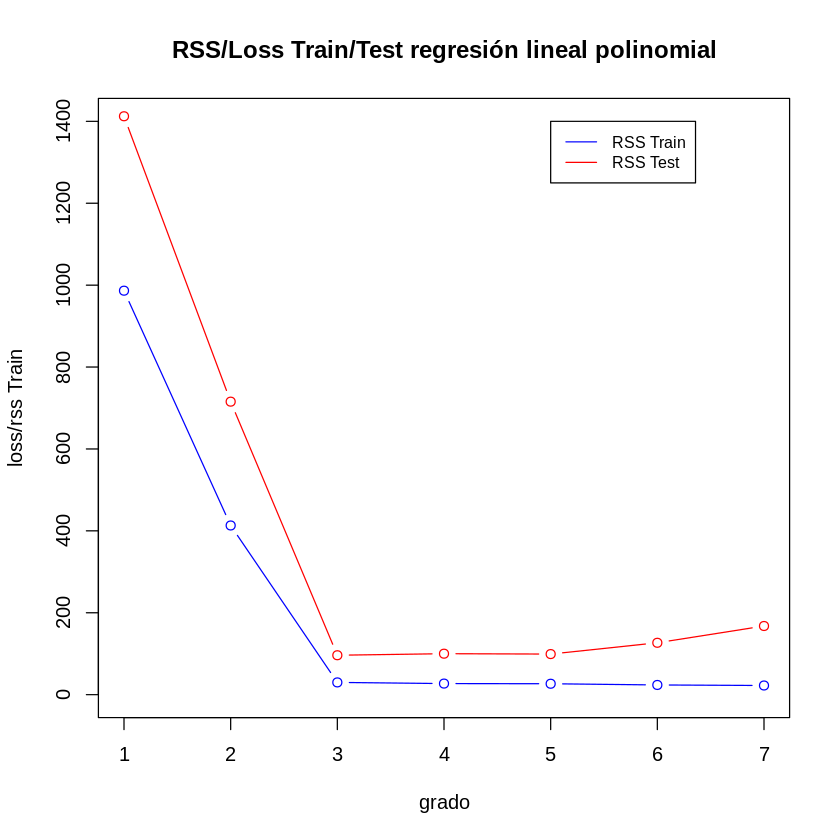

In [24]:
#::GMG::Dibujo la evolución de rss en función del grado en train/test
#       Validación (hold-out)
plot(1:7,loss_tn, type = 'b', col = 'blue', 
     xlab = 'grado', ylab = 'loss/rss Train', 
     ylim = c(0,1400),
     main = 'RSS/Loss Train/Test regresión lineal polinomial')
lines(1:7,loss_tt, col = 'red',type = 'b')
legend(5, 1400, 
       legend=c('RSS Train', 
                'RSS Test'),
       col=c('blue', 'red'), lty= 1, cex=0.8)

### Conclusiones

**::GMG::** Aquí se puede observar de manera somera como (curva azul) el ajuste de los datos de entrenamiento con grados crecientes (complejidad) de polinomios reduce el error hasta que a partir de grado 3 el error se estabiliza (hay un efecto de escala aquí pero el valor es bajo) y un incremento de complejidad del modelo no disminuye de forma significativa el error. Hemos hecho que el modelo se ajuste bastante bien a los datos de entrenamiento.

Cuando llevamos al modelo al conjuto de datos de validación (curva roja) vemos que en los primeros modelos simples de pequeño grado se comete un gran error, superior al de entrenamiento. Estamos en la zona de "underfitting". El error se va reduciendo hasta un mínimo en el grado 3, superior al de entrenamiento. Este gap se mantiene más o menos en los gradpos 4 y 5. Estamos en la zona "just right fit" en el que la generalización (bias/variance) no es mala (habría que cuantificar el bias y variance de la estimación). 

A partir del grado 5 las curvas vuelven a diverger. El modelo está  muy bien ajustado a los datos de entrenamiento pero a la hora de predicir vuelve a incrementar el error. Estamos en la zona de "overfit".

### Regularización Ridge (L2)

 4. Escribe una función de R que encuentre el mínimo de la función de coste para el caso de regularización L2. El parámetro lambda será pasado como input.

In [25]:
#::GMG::Introducimos L2 en la regresión lineal
# https://www.statmethods.net/advstats/matrix.html
# https://www.rdocumentation.org/packages/base/versions/3.5.2/topics/diag
# s17 presentación de clase (normal equation con el término de penalización)
betas_reg <- function (lambda,x,y) {
    i <- rep(1, length(y))
    X <- cbind(i,x)
    Y <- matrix(y, nrow = length(y))
    I <- diag(x = 1, nrow = ncol(X))
    B_hat <- solve(t(X) %*% X + lambda * I) %*% t(X) %*% Y
    return (as.numeric(B_hat))
}

In [26]:
#::GMG::Me hago mi función de regresión lineal con rss() y betas_reg()
mi_lm_reg <- function(lambda,x,y) {
    coef <- betas_reg(lambda= lambda, x = x,y = y)
    loss <- rss(betas = coef,x = x,y = y)
    list(coeficientes = coef, rss = loss)
}

- Utilízala para estimar las curvas que mejor ajustan para el caso de (4 parámetros, lambda = 0), (7 parámetros, lambda=0) y (7 parámetros, lambda=1000).

In [27]:
#::GMG::Primer caso: grado 4 y lambda = 0
model_1 <- mi_lm_reg(lambda = 0, 
                     x = poly(x = x_train, degree = 4, raw = T), 
                     y = y_train)
print(model_1$coeficientes)
print(model_1$rss)

[1] -0.74926098 -1.62943983  1.47145887  1.08627502  0.05114421
[1] 27.08974


In [28]:
#::GMG::Validamos (hold-out) con mi_predict()
p_1 <- mi_predict(model = model_1, poly(x_test, 4, raw = T), y_test)
print(p_1$rss)

[1] 100.0625


In [29]:
#::GMG::Segundo: grado 7 y lambda = 0
model_2 <- mi_lm_reg(lambda = 0, 
                     x = poly(x = x_train,degree = 7, raw = T), 
                     y = y_train)
print(model_2$coeficientes)
print(model_2$rss)

[1] -0.97708785  0.15365402  3.12064190 -0.07450964 -0.53796861  0.24056963
[7]  0.04800586 -0.01546877
[1] 22.39617


In [30]:
#::GMG::Validamos (hold-out) con mi_predict()
p_2 <- mi_predict(model = model_2, poly(x_test, 7, raw = T), y_test)
print(p_2$rss)

[1] 167.6892


In [31]:
#::GMG::Tercer caso: grado 7 y lambda = 1000
model_3 <- mi_lm_reg(lambda = 1000, 
                     x = poly(x = x_train,degree = 7, raw = T), 
                     y = y_train)
print(model_3$coeficientes)
print(model_3$rss)

[1]  0.018373450  0.008320195  0.067636079  0.046075393  0.177207358
[6]  0.159007736  0.005416178 -0.007174958
[1] 92.77737


In [32]:
#::GMG::Validamos (hold-out) con mi_predict()
p_3 <- mi_predict(model = model_3, poly(x_test, 7, raw = T), y_test)
print(p_3$rss)

[1] 150.3749


**::GMG::** Aquí vemos de forma puntual como un incremento del grado de 4 a 7 lleva a la zona de overfitting e incrementa de manera significativa el error. Al aplicar la regularización L2 (Ridge) en el grado 7 el término de penalización que se añade actúa sobre los coeficientes de las variables de manera que el el error se ve reducido en cierta medida. Suavizando la curva del modelo en overfitting se ha conseguido predecir mejor.

- Pinta todas las curvas juntas y escribe tus conclusiones. 

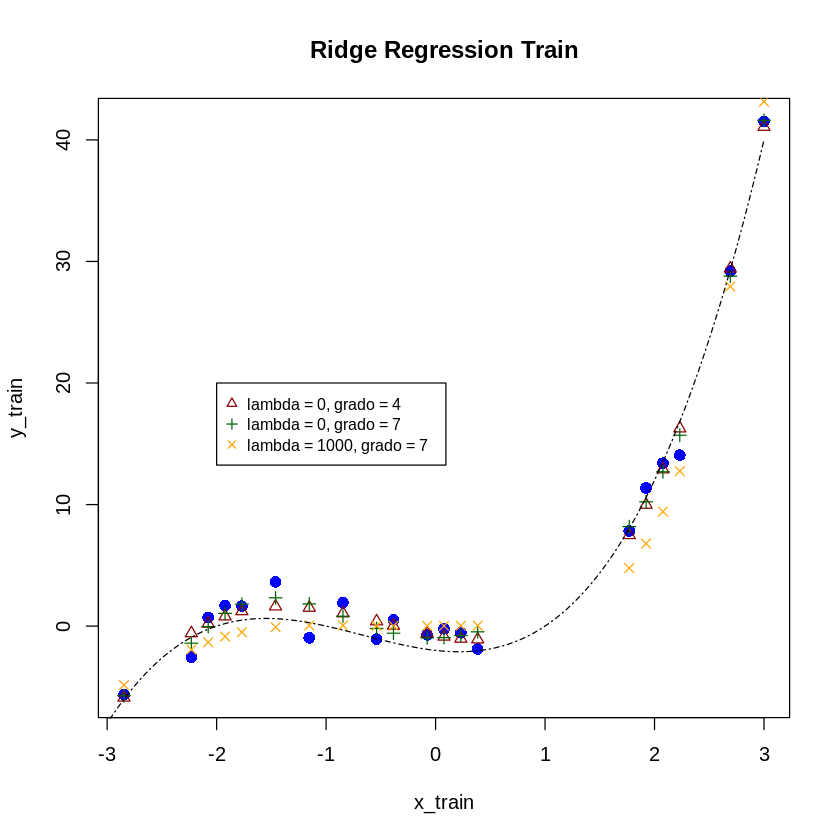

In [33]:
#::GMG::Pinto ajuste de puntos en el caso de Train
# http://www.sthda.com/english/wiki/add-legends-to-plots-in-r-software-the-easiest-way
#::nota::Aquí por alguna razón que desconozco NO puedo pintar líneas, solo puntos (!??)
plot(x_train,y_train, 
     pch = 16, cex = 1.3, col = 'blue',
     main = 'Ridge Regression Train')
points(x_train, 
       mi_predict(model = model_1, poly(x_train, 4, raw = T), y_train)$y_pred, 
       col='darkred', pch = 2)
points(x_train, 
       mi_predict(model = model_2, poly(x_train, 7, raw = T), y_train)$y_pred, 
       col='darkgreen', pch = 3)
points(x_train, 
       mi_predict(model = model_3, poly(x_train, 7, raw = T), y_train)$y_pred, 
       col='orange', pch= 4)
curve(expr = horner(x = x, v = b),from = -3, to = 3, add = T, lwd = 1, lty = 4)
legend(-2, 20, 
       legend=c('lambda = 0, grado = 4', 
                'lambda = 0, grado = 7', 
                'lambda = 1000, grado = 7'),
       col=c('darkred', 'darkgreen', 'orange'), pch=2:4, cex=0.8)

**::GMG::** Aquí vemos claramente el efecto de la aplicación de la regularización. Sin regularización (lambda = 0) un incremento de grado (complejidad) del modelo de 4 (triángulo) a 7 (cruz) hace que los puntos de entrenamiento (azul) sean ajustados más precisamente (en general) y en cuanto se aplica la regularización (aspas) los puntos se separan y *suavizan* (de cruz a a aspa) la curva resultante. 

**::DUDA::**: Aquí por alguna razón que desconozco *NO puedo pintar curvas*, solo puntos (!??)

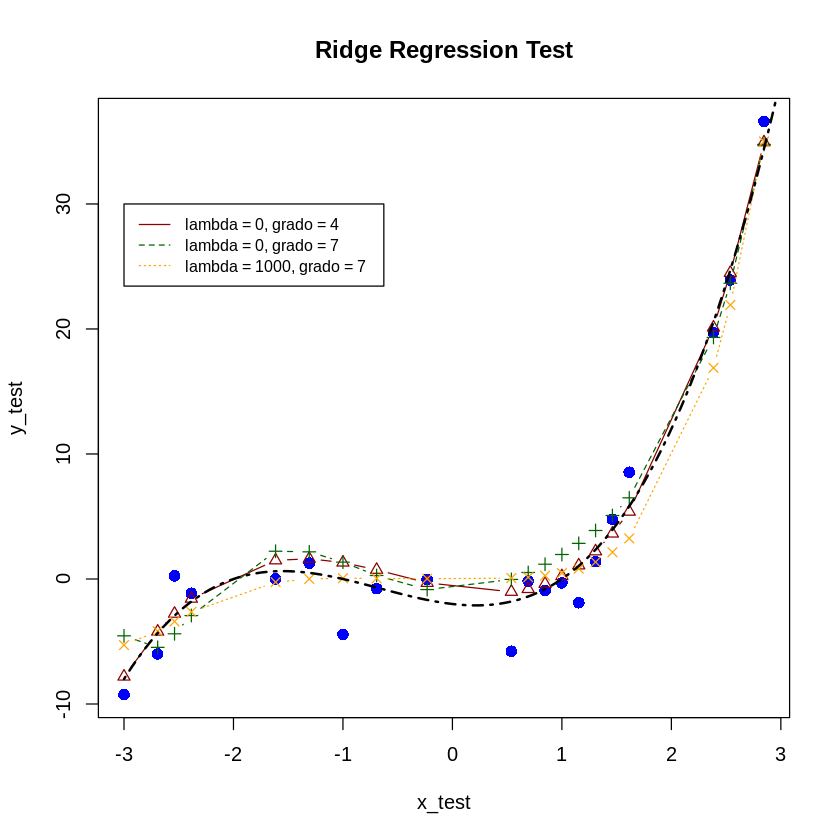

In [34]:
#::GMG::Pinto las curvas de ajuste en el caso de Test
# http://www.sthda.com/english/wiki/add-legends-to-plots-in-r-software-the-easiest-way
plot(x_test,y_test, 
     pch = 16, cex = 1.3, col = 'blue',
     main = 'Ridge Regression Test')
points(x_test, p_1$y_pred, col='darkred', type = 'b', lty = 1, pch = 2)
points(x_test, p_2$y_pred, col='darkgreen', type = 'b', lty = 2, pch = 3)
points(x_test, p_3$y_pred, col='orange', type = 'b', lty = 3, pch = 4)
curve(expr = horner(x = x, v = b),from = -3, to = 3, add = T, lwd = 2, lty = 4)
legend(-3, 30, 
       legend=c('lambda = 0, grado = 4', 
                'lambda = 0, grado = 7', 
                'lambda = 1000, grado = 7'),
       col=c('darkred', 'darkgreen', 'orange'), lty=1:3, cex=0.8)

**::GMG::** Las curvas predichas en el caso de test. Vemos el efecto en la generalización de la aplicación de Ridge L2 a nuestros modelos de grado 7 (verde y naranja). Se observar el efecto de suavizado de la penalización sobre todo en los intervalos (-3,0) y (1,3). En esta caso el lambda aplicado empeora la predicción para valores positivos de 1 a 2.5 pero en conjunto disminuye el RSS, como hemos visto anteriormente con los resultados numéricos. 

Entiendo que un análisis propio de ese efecto tendría que hacerse con un CV (en lugar de hold-out) y medidas como MSE o RMSE junto con test estadísticos potentes ... (**::DUDA::** ¿cuáles?)


5. Utiliza la función anterior para representar el valor de los parámetros del modelo en función de $\lambda$. Prueba a representar la evolución de los coeficientes de un modelo de 11 parámetros.

In [35]:
#::GMG::Rango de penalizaciones que voy a probar
lambdas <- c(1,10,100,1000, 10000, 100000)

In [36]:
#::GMG::Obtengo los coeficientes en una lista
Coeficientes <- list()

for (L in log10(lambdas)) {
    Coeficientes[[L+1]] <- mi_lm_reg(lambda = lambdas[L+1], 
                     x = poly(x = x_train,degree = 11, raw = T), 
                     y = y_train)$coeficientes
}

In [37]:
#::GMG::Convierto la lista en una matriz de NxM
#::nota::N modelos x M coeficientes
C <- do.call(rbind, Coeficientes)

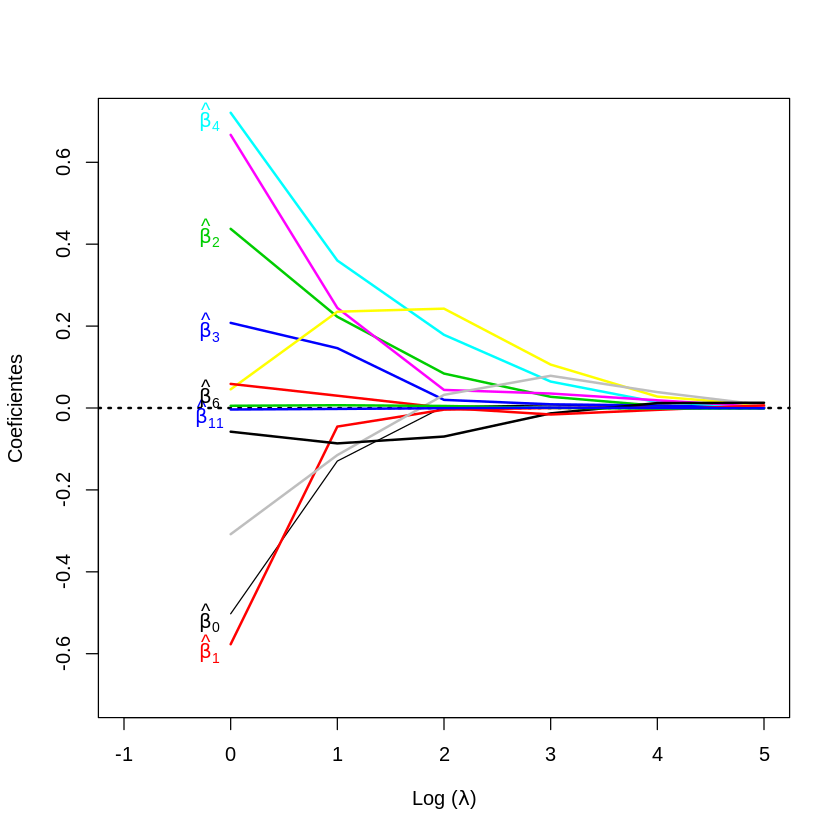

In [44]:
#::GMG::Pinto la base del gráfico con la línea punteada del cero en negro y 
#       el primer parámetro
plot(log10(lambdas), 
     C[,1], 
     xlim = c(-1,5), ylim = c(-0.7, 0.7),
     xlab = expression(paste('Log (', lambda,')')),
     ylab = 'Coeficientes', 
     type = 'l',
     col = 'black')
abline(h=0, col='black',lty = 3, lwd = 2)
#::GMG::Dibujo la evolución de cada coeficiente en lambda (columna de C)
for (i in 2:12) {
  lines(log10(lambdas), 
         C[,i], 
         col=i, 
         pch=2, 
         lwd = 2)
}
#::GMG::Marco algunos parámetros
text(-0.2, 
     C[1,1] - 0.01, 
     labels = expression(hat(beta)[0]),
     col = 'black')
text(-0.2, 
     C[1,2] - 0.01, 
     labels = expression(hat(beta)[1]),
     col = 2)
text(-0.2, 
     C[1,3] - 0.01, 
     labels = expression(hat(beta)[2]),
     col = 3)
text(-0.2, 
     C[1,4] - 0.01, 
     labels = expression(hat(beta)[3]),
     col = 4)
text(-0.2, 
     C[1,5] - 0.01, 
     labels = expression(hat(beta)[4]),
     col = 5)

text(-0.2, 
     C[1,12] - 0.01, 
     labels = expression(hat(beta)[11]),
     col = 12)

text(-0.2, 
     C[1,7] - 0.01, 
     labels = expression(hat(beta)[6]),
     col = 1)

**::DUDA::**  ¿Cómo se interpreta este gráfico?

**::GMG::** En teoría la regresión L2 (Ridge) penaliza los coefientes de manera que aquellos que aportan menos en la estimación van a tender a cero (*shrink*) más rápidamente. En el gráfico de arriba cada línea representa un coeficiente cuyo valor tiende a cero a medida que se incrementa la penalización (*$\lambda$*). Además se puede uno imaginar que a partir de 1000, la penalización es tan alta que deja muy poco a repartir entre los coeficientes y todos se igualan a un valor muy bajo.

Creo que uno puede calificar (que no cuantificar) la importancia de un codeficiente por la velocidad con la que va para cero. Cuanto más rápido vaya, menos importante será. Vemos que un coeficiente de un término de alto grado, i.e. 11 tiene asignado un valor muy bajo ya se entrada. El rojo (grado 1) decrece muy rápido ya con el primer valor de lambda, al igual que el término de bias (grado cero) en negro. Resulta curiosa la evolución de los coeficientes gris y amarillo, sobretodo este último ($\hat \beta_6$, etiquetada en negro para que se vea) que incrementa su importancia relativa hasta un pico en $\lambda$ = 100.

Esta gráfica no sirve para coger el *mejor lambda*. Se debería hacer una gráfica del error de predicción en función de lambda. Una vez determinado ese lambda óptimo se podría venir a esta gráfica y hacer la comparación de la importancia los coeficientes en ese punto.